## Practica 1 - Computer Vision

In [113]:
import os
import gdown

# Crear el directorio de datos si no existe
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# URL de Google Drive en formato correcto para gdown
url = "https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE"
zip_filename = "practica_1_dataset.zip"
zip_path = os.path.join(data_dir, zip_filename)

# Descargar el archivo
if not os.path.exists(zip_path):
    gdown.download(url, zip_path, quiet=False)
else:
    print("Data zipfile already exists")


Downloading...
From (original): https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE
From (redirected): https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE&confirm=t&uuid=a19a28d5-c55f-47b7-a31a-b0b2a82e8efd
To: /home/alf/git-repos/PracticasDeepLearning/P1_ComputerVision/data/practica_1_dataset.zip
100%|██████████| 69.6M/69.6M [01:16<00:00, 910kB/s] 


In [114]:
import os
from pathlib import Path
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

data_dir = "data"
zip_filename = "practica_1_dataset.zip"
zip_path = os.path.join(data_dir, zip_filename)
subfolders = ["test", "train", "valid"]
full_paths = [os.path.join(data_dir, folder) for folder in subfolders]

if not all(os.path.isdir(path) for path in full_paths):
    with ZipFile(zip_path, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if not file.startswith("__MACOSX"):
                    exe.submit(zf.extract, file, path=data_dir)
else:
    print("test, train and valid folders already exist")

In [115]:
import tensorflow as tf

for folder in subfolders:
    folder_path = os.path.join(data_dir, folder)
    ds_files = tf.data.Dataset.list_files(folder_path + "/*.jpg", shuffle=False)
    print(f"Total image files in {folder}: {len(ds_files)}")
    print("Filenames shape:", ds_files.element_spec)

example = next(ds_files.take(1).as_numpy_iterator())
example

Total image files in test: 63
Filenames shape: TensorSpec(shape=(), dtype=tf.string, name=None)
Total image files in train: 448
Filenames shape: TensorSpec(shape=(), dtype=tf.string, name=None)
Total image files in valid: 127
Filenames shape: TensorSpec(shape=(), dtype=tf.string, name=None)


b'data/valid/IMG_2277_jpeg_jpg.rf.86c72d6192da48d941ffa957f4780665.jpg'

In [116]:
import pandas as pd
data_dir = "data"
df = pd.read_csv(os.path.join(data_dir, "test", "annotations.csv"))
print(f"{df.shape = }")
df.head()

df.shape = (584, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,406,457,497,533
1,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,18,705,82,759
2,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,51,426,116,475
3,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,428,331,504,376
4,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,0,613,21,658


In [117]:
import os
import pandas as pd
import numpy as np

def annotation_to_labels(annotations_path):
    # Load the annotations
    df = pd.read_csv(annotations_path)

    # Count the number of instances of each class per image
    count_class = df.groupby(["filename", "class"]).size()

    # Compute the area of each bounding box
    df["area"] = (df["xmax"] - df["xmin"]) * (df["ymax"] - df["ymin"])

    # Compute the area of each class per image
    area_class = df.groupby(["filename", "class"])["area"].sum()
    
    # Compute the score as AREA * COUNT
    score = pd.Series(area_class * count_class, name="score").reset_index()

    # Group by filename and get the class with the highest score
    df_labels = score.groupby("filename").max().reset_index()

    return df_labels["filename"].values, df_labels["class"].values

data_dir = "data"
filenames, labels = annotation_to_labels(os.path.join(data_dir, "test", "annotations.csv"))
filenames[:5], labels[:5]

(array(['IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg',
        'IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg',
        'IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg',
        'IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg',
        'IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg'],
       dtype=object),
 array(['puffin', 'penguin', 'penguin', 'penguin', 'penguin'], dtype=object))

In [118]:
import shutil
def organize_by_label(filenames, labels, data_dir):
    # Define input and output paths
    filepaths = np.char.add(data_dir + os.sep, filenames)
    organized_filepaths = np.char.add(data_dir + os.sep + labels + os.sep, filenames)

    # Create a directory for each label
    for label in np.unique(labels):
        os.makedirs(data_dir + os.sep + label, exist_ok=True)
    
    # Move files to their respective directories
    def move_file(src, dest):
        try:
            shutil.move(src, dest)
            return True  # File moved successfully
        except FileNotFoundError:
            if not os.path.exists(dest):
                print(f"Annotated file not found: {src}")
            return False  # File does not exist
        except Exception as e:
            return f"Error: {e}"

    return np.vectorize(move_file)(filepaths, organized_filepaths)

data_dir = os.path.join("data", "test")
organize_by_label(filenames, labels, data_dir)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [183]:
set_names = ["train", "valid", "test"]
for set_name in set_names:
    data_dir = os.path.join("data", set_name)
    filenames, labels = annotation_to_labels(os.path.join(data_dir, "annotations.csv"))
    organize_by_label(filenames, labels, data_dir)

In [184]:
data_dir = os.path.join("data", "test")
image_paths = tf.data.Dataset.list_files(
    data_dir + os.sep + '*/*.jpg',
    shuffle=False
)  # Note: Pattern only looks inside subfolders
print(image_paths.as_numpy_iterator().next())

b'data/test/fish/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg'


## Create tf.data.Dataset

In [226]:
set_names = ["train", "valid", "test"]
data_dir = "data"
ds = {
    name: tf.data.Dataset.list_files(
        os.path.join(data_dir, name) + os.sep + '*/*.jpg',
        shuffle=False,
    )
    for name in set_names
}
ds

{'train': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 'valid': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 'test': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>}

In [227]:
next(ds["test"].as_numpy_iterator())

b'data/test/fish/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg'

In [228]:
def get_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def get_label(image_path):
    label = tf.strings.split(image_path, os.sep)[-2]
    return label

for key in ds.keys():
    ds[key] = ds[key].map(
        lambda x: (get_image(x), get_label(x)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>}

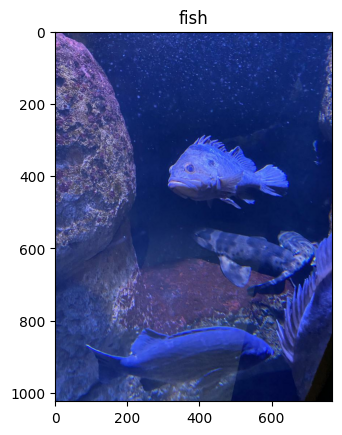

In [229]:
import matplotlib.pyplot as plt

image, label = next(ds["test"].as_numpy_iterator())

plt.imshow(image)
plt.title(label.decode("utf-8"))
plt.show()

In [ ]:
def normalize_image(image):
    image = tf.image.resize_with_crop_or_pad(image, 1024, 1024)
    return image

for key in ds.keys():
    ds[key] = ds[key].map(
        lambda x, y: (normalize_image(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>}

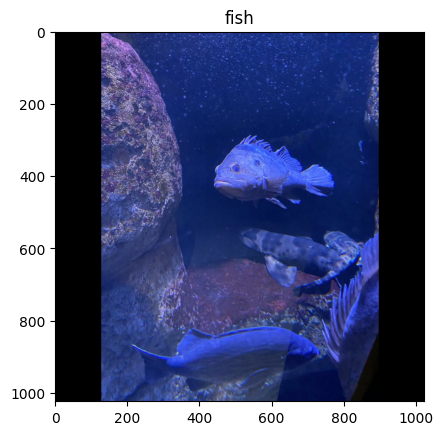

In [231]:
import matplotlib.pyplot as plt

image, label = next(ds["test"].as_numpy_iterator())

plt.imshow(image)
plt.title(label.decode("utf-8"))
plt.show()

In [232]:
class_mapping = {
    0: b"fish",
    1: b"jellyfish",
    2: b"penguin",
    3: b"puffin",
    4: b"shark",
    5: b"starfish",
    6: b"stingray",
}

class_lookup_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(class_mapping.values())), 
        values=tf.constant(list(class_mapping.keys()), dtype=tf.int64)
    ), 
    default_value=-1
)

def normalize_label(label):
    return class_lookup_table.lookup(label)

for key in ds.keys():
    ds[key] = ds[key].map(
        lambda x, y: (x, normalize_label(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

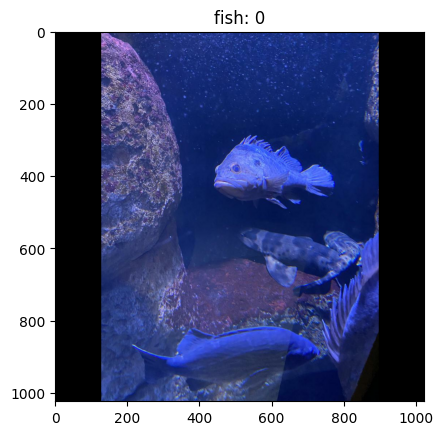

In [235]:
import matplotlib.pyplot as plt

image, label = next(ds["test"].as_numpy_iterator())

plt.imshow(image)
plt.title(f"{class_mapping[label].decode()}: {label}")
plt.show()

In [236]:
for key in ds.keys():
    ds[key] = ds[key].map(
        lambda x, y: (x, tf.one_hot(y, depth=7)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

In [240]:
import matplotlib.pyplot as plt
iter_ds = iter(ds["test"].take(3))
for el in iter_ds:
    image, label = el
    print(label)

tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)


2025-03-30 19:18:24.819814: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [241]:
for key in ds.keys():
    ds[key] = ds[key].map(
        lambda x, y: (tf.cast(x, tf.float32)/255, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

In [242]:
iter_ds = iter(ds["test"].take(3))
for el in iter_ds:
    image, label = el
    print(image)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(1024, 1024, 3), dtype=float32)
tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 

```python
AUTOTUNE = tf.data.AUTOTUNE

ds_files = tf.data.Dataset.list_files("data/test/" + '*.jpg', shuffle=False)
df = pd.read_csv("data/test/annotations.csv")
df["class"] = pd.Categorical(df["class"])
ds_images = (
    ds_files
    .shuffle(len(ds_files))
    .cache()
    .map(lambda x: (get_image(x), get_label(x, df)), num_parallel_calls=AUTOTUNE)
)

print("Total images:", len(ds_images))
print("Image shape:", ds_images.element_spec)